### Import libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import seaborn as sns
from scipy.stats import mstats as stats
import scikit_posthocs as sp
pd.options.mode.chained_assignment = None 

%matplotlib inline

/Users/egill/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Gather the data (data were downloaded from https://www.kaggle.com/ahsen1330/us-police-shootings), 
and read it in as a pandas DataFrame

In [2]:
df = pd.read_csv("data/datasets_806447_1382162_shootings.csv")

### Business understanding
The dataset was compiled from various other Kaggle datasets by the Kaggle user because he wanted to perform analyses surrounding the issue of racism. While there are many very valid questions surrounding this issue, I wanted to explore this dataset from a different angle.

#### The range of the victims' ages is extremely broad: from 6 to 91.

This fact leads to it's own suite of questions:
* What factors are correlated with a victim's age?
* Specifically, which factors are correlated with a victim being younger?
* Are unarmed individuals of certain ages more likely to be killed?
* Is an individual more likely to be killed at a certain age based on location?

### Assess the data: Data Understanding

In [3]:
#get a brief overview of the columns in the dataframe and the data in the columns
df.describe(include = "all")

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
count,4895.000000,4895,4895,4895,4895,4895.000000,4895,4895,4895,4895,4895,4895,4895,4895,4895
unique,NaN,4851,1792,2,89,NaN,2,6,2288,51,2,3,4,2,12
top,NaN,TK TK,2018-06-29,shot,gun,NaN,M,White,Los Angeles,CA,False,attack,Not fleeing,False,Guns
freq,NaN,29,9,4647,2755,NaN,4673,2476,78,701,3792,3160,3073,4317,2764
mean,2902.148519,NaN,NaN,NaN,NaN,36.549750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1683.467910,NaN,NaN,NaN,NaN,12.694348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.000000,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1441.500000,NaN,NaN,NaN,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2847.000000,NaN,NaN,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4352.500000,NaN,NaN,NaN,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#find the percent of data that is present in each column
(df.shape[0] - df.isnull().sum())/df.shape[0] * 100

id                         100.0
name                       100.0
date                       100.0
manner_of_death            100.0
armed                      100.0
age                        100.0
gender                     100.0
race                       100.0
city                       100.0
state                      100.0
signs_of_mental_illness    100.0
threat_level               100.0
flee                       100.0
body_camera                100.0
arms_category              100.0
dtype: float64

* All of the values are present in the dataset, so we won't have to fill any
* There are many variables that we can use to build a model that explores factors correlated with victims' ages.
* We can proceed to the next step of the data science process 

### Perform some basic analyses on the data
let's start by looking at geographic location

In [5]:
df['state'].value_counts().head()

CA    701
TX    426
FL    324
AZ    222
CO    168
Name: state, dtype: int64

California has by far the most shootings.


Does the threat level of victims play a role in their deaths?

In [6]:
df['threat_level'].value_counts()

attack          3160
other           1528
undetermined     207
Name: threat_level, dtype: int64

Individuals who are "attacking" are about twice as likely to be shot as individuals who are not.


Let's look at the races of individuals who are shot.

In [7]:
print(df['race'].value_counts()) #number of individuals of each race
print(df['race'].value_counts()/len(df)*100) #percent of individuals of each race

White       2476
Black       1298
Hispanic     902
Asian         93
Native        78
Other         48
Name: race, dtype: int64
White       50.582227
Black       26.516854
Hispanic    18.426966
Asian        1.899898
Native       1.593463
Other        0.980592
Name: race, dtype: float64


Individuals who are White make up about 50% of individuals who are shot, followed
by individuals who are Black (~26%) and Hispanic (~18%).


What about the types of weapons that victims have in their possession when they are killed?

In [8]:
df['armed'].value_counts()

gun                                 2755
knife                                708
unknown                              418
unarmed                              348
toy weapon                           171
                                    ... 
grenade                                1
baseball bat and fireplace poker       1
flashlight                             1
air conditioner                        1
motorcycle                             1
Name: armed, Length: 89, dtype: int64

There are 89 different types of weapons here - luckily the entries in this column have been
grouped into 12 types in the "arms_categry" column.


In [9]:
df['arms_category'].value_counts()

Guns                     2764
Sharp objects             818
Unknown                   418
Unarmed                   348
Other unusual objects     192
Blunt instruments         122
Vehicles                  121
Multiple                   54
Piercing objects           29
Electrical devices         24
Explosives                  4
Hand tools                  1
Name: arms_category, dtype: int64

The most common weapon victims have in their possession in a gun. 

There are only a handful of observations of individuals who are armed with explosives or 
hand tools. This will be important to keep in mind later.


Now let's get a better look at the distribution of our variable of interest: age

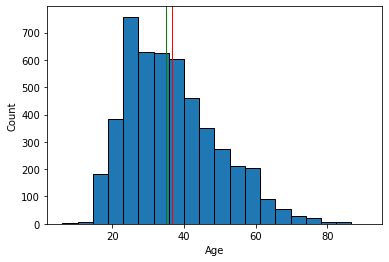

In [10]:
#we'll plot a histogram to visualize the age distribution of the victims
plt.hist(df['age'], bins=20, edgecolor="black")
plt.xlabel('Age')
plt.ylabel('Count')
#let's plot the data mean with a red line
plt.axvline(df['age'].mean(), color="red", linewidth = 1)
#and the data median with a green line
plt.axvline(df['age'].median(), color="green", linewidth = 1)

Looks like the data are skewed right. 


**Question**: Does the distribution differ by race?


We saw above that most victims are White, Black or Hispanic - 
let's just look at these races to simplify the plot.


We'll plot overlapping histograms and normalize them so we can compare directly.

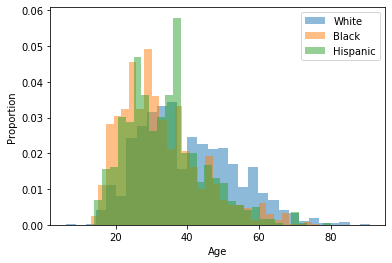

In [11]:
#first we'll subset the dataframe into smaller dataframes, each containing 
#information for individuals of a different race
w_age = df[df['race'] == 'White'] #white individuals dataframe
b_age = df[df['race'] == 'Black'] #black individuals dataframe
h_age = df[df['race'] == 'Hispanic'] #hispanic individuals dataframe

#now we'll plot the histograms
bins = 30
plt.hist(w_age['age'], bins, alpha=0.5, label='White', density = 1) #white individuals histogram
plt.hist(b_age['age'], bins, alpha=0.5, label='Black', density = 1) #black individuals histogram
plt.hist(h_age['age'], bins, alpha=0.5, label='Hispanic', density = 1) #hispanic individuals histogram
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.legend(loc='upper right')
plt.show()

These distributions don't completely overlap - there seem to be more Black and Hispanic victims that are younger,
and more White victims that are older. We can see if this shows up in the model that we fit as well.

Let's investigate which factors are associated with victims' ages in more detail.

### Data Preparation

* First, we'll remove 'name', 'date' and 'id' from the dataset because these are unlikely to be informative.
* We'll also remove 'armed' because it is co-linear with 'arms category'.
* We'll remove city because this is a categorical variable that will have to be dummied and is likely to have a lot of unique values. This could reduce the power of our model.
* We'll remove 'state' for now, but will investigate this later on.
* Note that since we don't have null values, we won't have to fill any in our dataset.

In [12]:
df_clean = df.drop(['name', 'date', 'id', 'city', 'armed', 'state'], axis = 1)

#Now let's dummy the the cat variables so that we can fit a linear model
def create_dummy_df(df, cat_cols, dummy_na):
    
    ''' function to dummy categorical variables
    inputs:
    - df (dataframe): datframe containing categorical variables 
    - cat_cols (list): a list of column names from the data frame that contain categorical 
    data that you want to dummy
    - dummy_na (boolean): True or False value indicating whether you would like a separate
    column for NA values
    
    returns:
    - a dataframe where all of the columns listed in cat_cols have been dummied'''
    
    for col in  cat_cols:
        try:
            # for each cat var add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

cat_df = df_clean.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

df_new = create_dummy_df(df_clean, cat_cols_lst, dummy_na=False) 

y = df_new['age']
X = df_new.drop(['age'], axis = 1)  

### Data Modelling

In [13]:
#Now we'll perform multiple linear regression
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=8) 

#fit the model
lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

### Evaluate the Results

In [14]:
#evaluate model
y_train_preds = lm_model.predict(X_train)
train_score = (r2_score(y_train, y_train_preds))
    
y_test_preds = lm_model.predict(X_test) 
test_score = (r2_score(y_test, y_test_preds))
 

print(test_score, train_score)


0.09689552849917127 0.12470647907077648


Looks like our model explains about 10% of the variance in the victims' ages.


Let's find out which factors explain the most variance in the age at which 
an individual is shot by police

In [15]:
def coef_weights(coefficients, X_train):
    
    ''' function to create a table that contains model coefficients sorted
    by absolute value
    inputs:
    - coefficients (.coef_ object from linear model): object that contains the variable names and weights
    of the coefficients from a linear model
    - X_train (DataFrame): the X values of the training data used to fit the linear model
    
    returns:
    - A dataframe containing the names of coefficents in the linear model, their values and their
    absolute values. The dataframe is sorted by the absolute values of the coefficients.'''
    
    coefs_df = pd.DataFrame() #make and empty DataFrame
    coefs_df['est_int'] = X_train.columns #add the variable names from the training dataset  
    coefs_df['coefs'] = lm_model.coef_ #add the linear model coefficients
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_) #add the absolute values of the coefficients
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False) #sort the DataFrame
    return coefs_df


coef_df = coef_weights(lm_model.coef_, X_train)

#look at the results
coef_df

,est_int,coefs,abs_coefs
17,arms_category_Hand tools,-12.194928,12.194928
24,arms_category_Vehicles,-4.984949,4.984949
19,arms_category_Other unusual objects,-4.763851,4.763851
22,arms_category_Unarmed,-4.724257,4.724257
15,arms_category_Explosives,-4.509056,4.509056
6,race_Native,-4.316744,4.316744
18,arms_category_Multiple,-4.160925,4.160925
12,flee_Not fleeing,3.947158,3.947158
4,race_Black,-3.600369,3.600369
8,race_White,3.276002,3.276002


It looks like the type of weapon a victim has in their possession is 
correlated with their age - at the top of the list, being armed with a 
hand tool is inversely correlated with age. Being unarmed is also inversely 
correlated with age, so younger people are most likely to be shot while unarmed 
or armed with hand tools.

Age is also inversely correlated with being Native, Black, Hispanic or "Other", 
while it is positively correlated with being White. 

Individuals who are not fleeing are likely to be older.

### Visualization of the results


**Question**: How do the distributions of ages of individuals who have different
types of arms in their possession compare to each other?

Guns                     2764
Sharp objects             818
Unknown                   418
Unarmed                   348
Other unusual objects     192
Blunt instruments         122
Vehicles                  121
Multiple                   54
Piercing objects           29
Electrical devices         24
Explosives                  4
Hand tools                  1
Name: arms_category, dtype: int64

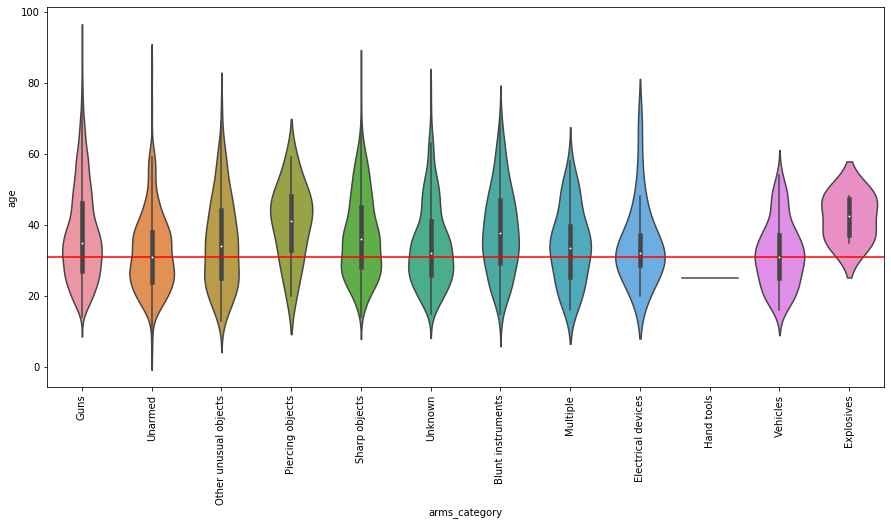

In [16]:
df_plot = df_clean[['arms_category', 'age']]

fig, ax = plt.subplots(figsize = (15, 7))
sns.violinplot(x = df_plot['arms_category'], y = df_plot['age']) #make violinplot
plt.xticks(rotation=90)

#plot median age of unarmed individuals as horizontal red line - I'm plotting the median 
#because we know that the ages are not normally distributed, so this is more appropriate.
plt.axhline(y = df_plot[df_plot['arms_category'] == 'Unarmed'].age.median(), color = 'r')

#Let's also look at the number of observations we have for each type of weapon
df_clean['arms_category'].value_counts()

The median age of unarmed victims is lower than victims who possess almost any
type of arms. 


It is also important to note that there are very few observations of
individuals who are armed with hand tools and exploseives. **This is definitely
an example of a situation where you need to check the number of observations 
for each category before assuming significance.** Statistical models cannot be
assumed to be representative of the general population you're trying to model
when you only have a few observations.


Now let's examine location in more detail to determine if there is a relationship
with age.

In [17]:
df_clean = df.drop(['name', 'date', 'id', 'city', 'armed'], axis = 1)

#Now let's dummy the the cat variables
cat_df = df_clean.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

df_new = create_dummy_df(df_clean, cat_cols_lst, dummy_na=False) 

y = df_new['age'] #create y dataset
X = df_new.drop(['age'], axis = 1) #create X dataset 


#Now we'll fit a linear model
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=8) 


lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) #fit the model

#evaluate model
y_train_preds = lm_model.predict(X_train)
train_score = (r2_score(y_train, y_train_preds))
    
y_test_preds = lm_model.predict(X_test) 
test_score = (r2_score(y_test, y_test_preds))
 

print(test_score, train_score)

0.09682805267143235 0.14058567811730815


These r2 values are very similar to the ones we got last time, so the quality of the model didn't change much.


Let's look at the model coefficients.

In [18]:
coef_df = coef_weights(lm_model.coef_, X_train) #Make a table to show the weights of the different
#model coefficents

#A look at the top results
coef_df

,est_int,coefs,abs_coefs
47,state_RI,12.622271,12.622271
67,arms_category_Hand tools,-11.012161,11.012161
42,state_NY,8.155974,8.155974
15,state_DC,8.123174,8.123174
29,state_ME,6.681051,6.681051
...,...,...,...
0,signs_of_mental_illness,0.887233,0.887233
1,body_camera,-0.429803,0.429803
3,gender_M,-0.288270,0.288270
2,manner_of_death_shot and Tasered,-0.183466,0.183466


Looks like the state in which the victim is shot is indeed 
correlated with the victim's age. 

Individuals who are shot in Rhode Island, New York, the District of Columbia 
and Maine are likely to be older - these are 4 of the top 5 coefficients in the model.

Let's visualize this so we can inspect the results

**Question**: Is there a relationship between location and the victims' ages?

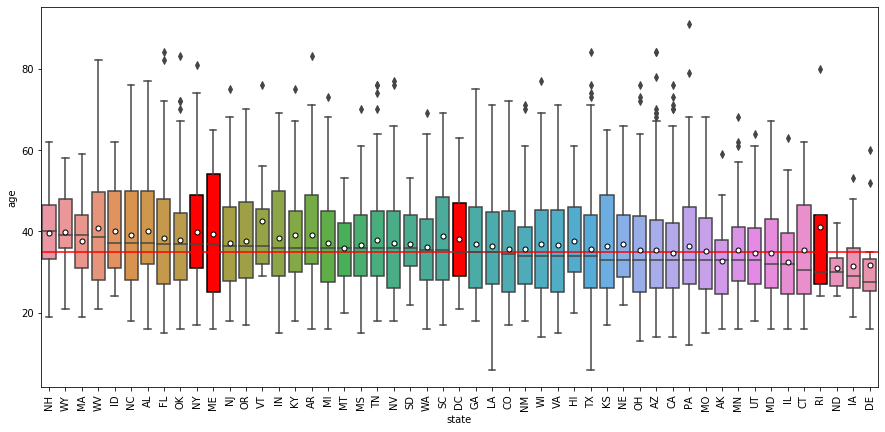

In [19]:
df_plot = df_clean[['state', 'age']]
#plot the states' ages in decreasing order
age_sorted_median = df_plot.groupby(by=["state"])["age"].median().sort_values().iloc[::-1].index

#make boxplot containing distribution of ages of all states
#the medians will be plotted as horizontal black lines, 
#the means will be plotted as white circles
fig, ax = plt.subplots(figsize = (15, 7))
ax = sns.boxplot(x = df_plot['state'], y = df_plot['age'], order = age_sorted_median, showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"5"})
plt.xticks(rotation=90)
#plot median age as horizontal red line - I'm plotting the median 
#because we know that the ages are not normally distributed, so this is more appropriate.
plt.axhline(y = df_plot['age'].median(), color = 'r')

#let's also make the RI, NY, DC and ME boxes red so they stand out in the plot
def find_index(lst, items):
    
    ''' function to find the index of one or more items in a list
    inputs:
    lst (list): the list that you want to find items in
    items (str, int, list, float, etc.): one item or a list of items that you
    want to locate in the larger list
    
    returns:
    the list indices of all items in "items"'''
    
    return [i for i, x in enumerate(lst) if x in items]

for box in (find_index(list(age_sorted_median), ['RI', 'NY', 'ME', 'DC'])):
    box = ax.artists[box]
    box.set_facecolor('red')
    box.set_edgecolor('black')


When we inspect the age data for each state more closely, it is difficult to understand why the coefficients of some of these states are so large.

Let's look at how many and what percent of shootings actually took place in these states.

In [20]:
print(df_clean['state'].value_counts()) #number of shootings in each state
print(df_clean['state'].value_counts()/len(df_clean) * 100) #percent of shootings in each state


CA    701
TX    426
FL    324
AZ    222
CO    168
GA    161
OK    151
NC    148
OH    146
WA    126
TN    125
MO    124
LA    102
IL     99
AL     95
PA     95
NM     93
VA     92
IN     91
NY     90
WI     88
KY     87
NV     85
SC     80
MD     77
OR     76
AR     73
MI     71
MS     61
MN     60
NJ     60
UT     58
KS     49
WV     46
ID     37
AK     36
MA     33
IA     31
MT     29
HI     29
NE     24
ME     21
CT     20
SD     14
DC     13
WY     13
NH     12
ND     11
DE     10
VT      8
RI      4
Name: state, dtype: int64
CA    14.320735
TX     8.702758
FL     6.618999
AZ     4.535240
CO     3.432074
GA     3.289070
OK     3.084780
NC     3.023493
OH     2.982635
WA     2.574055
TN     2.553626
MO     2.533197
LA     2.083759
IL     2.022472
AL     1.940756
PA     1.940756
NM     1.899898
VA     1.879469
IN     1.859040
NY     1.838611
WI     1.797753
KY     1.777324
NV     1.736466
SC     1.634321
MD     1.573034
OR     1.552605
AR     1.491318
MI     1.450460
MS     1.246170


* 4 (0.08%) of the shootings took place in RI
* 13 (0.27%) of the shootings took place in DC
* 21 (0.43%) of the shootings took place in ME
* 90 (1.84%) of the shootings took place in NY

With the exception of New York, these states are among the ten in which the fewest shootings took place. The ages are also extremely widely distributed (the bar charts have large error bars, especially given the small number of observations). 

**This is another example of a situation where you need to check the number of observations 
for each category before assuming significance.**

### Determine differences in victims' ages by state, take 2

Let's try to determine the correlation between age and state alone, but filter for sample size.
* We'll remove data from any states that have less than 50 shootings
* This is because when you're performing correlation tests on a sample where n = 50, you're likely to observe a correlation between -0.18 and 0.18 (not necessarily 0, but approaching 0) about 80% of the time when the correlation is actually 0. *BUT* the other 20% of the time, you'll get a correlation that is either > 0.18 or < -0.18.
* When you decrease n to 25, the 80% confidence interval for correlation increases to a range of -0.25 to 0.26
* |0.26| is far greater than the r2 score we got for our complete linear regression model, so it would be imprudent to work with that level of imprecision.
* Increasing n to 100 would only decrease the 80% confidence interval for correlation to a range of -0.13 to 0.13, and we only have 13 states where >= 100 shootings occurred
* Therefore, using a cutoff of 50 will allow us to use the majority of the dataset in the analysis and to decrease the likelihood that we achieve significance by chance.

### Prepare Data

In [21]:
#first we'll get a list of states in which the number of shootings >= 50
shootings_by_state = df_clean['state'].value_counts().reset_index() 
shootings_by_state.columns = ['state', 'shootings']
shootings_by_state_50 = shootings_by_state[shootings_by_state['shootings'] >= 50]
state_list = list(shootings_by_state_50['state'])

#subset clean dataframe to include only data from these states
shootings_subset = df_clean[df_clean['state'].isin(state_list)]
#double-check the work
print(shootings_subset['state'].value_counts())


CA    701
TX    426
FL    324
AZ    222
CO    168
GA    161
OK    151
NC    148
OH    146
WA    126
TN    125
MO    124
LA    102
IL     99
AL     95
PA     95
NM     93
VA     92
IN     91
NY     90
WI     88
KY     87
NV     85
SC     80
MD     77
OR     76
AR     73
MI     71
MS     61
NJ     60
MN     60
UT     58
Name: state, dtype: int64


Instead of building a linear model this time, we'll use statistical tests to determine whether the distributions of ages differ by state. 
* We'll start with a Kruskal-Wallis test to determine whether any age distributions are different (this is appropriate because we don't have the same number of observations for each state, and the test is non-parametric.
* If we get a significant p-value, we'll use a post-hoc test (Dunn's test, which is the recommended post-hoc test for the Kruskal-Wallis test) to determine which states have significantly different age distributions.
* The premise behind this is that some states may have significantly lower or higher age distributions than others. This approach will capture both low and high cases.

In [22]:
state_df = pd.DataFrame() #make an empty dataframe
for i in state_list: #append age data for each state onto the dataframe separately
    state = pd.DataFrame(shootings_subset[shootings_subset['state'] == i]['age'])
    state_df = pd.concat([state_df, state], axis = 1, ignore_index=True, sort = False, join = 'outer')
    
state_df.colnames = state_list #rename the columns of the dataframe
#sort the dataframe so that ages start at row 0, then drop rows that contains all NaNs
state_df_sorted = pd.DataFrame(np.sort(state_df.values, axis=0), index=state_df.index, columns=state_df.columns)
state_df_sorted.dropna(axis = 0, how = 'all', inplace = True)
state_df_sorted.columns = state_list
state_df_sorted #inspect the dataframe

/Users/egill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,CA,TX,FL,AZ,CO,GA,OK,NC,OH,WA,...,NV,SC,MD,OR,AR,MI,MS,MN,NJ,UT
0,14.0,6.0,15.0,14.0,17.0,18.0,16.0,18.0,13.0,16.0,...,18.0,17.0,16.0,17.0,16.0,16.0,15.0,16.0,18.0,18.0
1,15.0,15.0,15.0,17.0,17.0,18.0,17.0,18.0,15.0,17.0,...,18.0,19.0,17.0,17.0,17.0,17.0,19.0,20.0,18.0,18.0
3,15.0,15.0,16.0,17.0,17.0,18.0,18.0,18.0,16.0,18.0,...,18.0,20.0,18.0,17.0,17.0,17.0,19.0,20.0,18.0,19.0
4,15.0,16.0,16.0,17.0,17.0,18.0,18.0,18.0,16.0,18.0,...,19.0,20.0,18.0,19.0,17.0,18.0,21.0,22.0,19.0,20.0
5,16.0,16.0,16.0,18.0,18.0,18.0,18.0,20.0,17.0,18.0,...,19.0,21.0,18.0,20.0,18.0,18.0,22.0,22.0,21.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
761,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
762,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
763,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Modeling (Statistical Testing)

In [23]:
#Kruskall Wallis H-test to determine whether any state stochastically dominates other states
H, pval = stats.kruskal([state_df_sorted[i] for i in state_df_sorted.columns])
print("H-statistic:", H)
print("P-Value:", pval)
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between states.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between states.")


H-statistic: 67.49252724138226
P-Value: 0.000161471860505154
Reject NULL hypothesis - Significant differences exist between states.


In [24]:
states_melted = state_df_sorted.melt(var_name='states', value_name='ages') # melt the dataframe
states_melted.dropna(axis = 0, how = 'any', inplace = True) # drop all NaN values

#perform the post-hoc test
p_values = sp.posthoc_dunn(states_melted, val_col = 'ages', group_col= 'states', p_adjust = 
                          'fdr_bh', sort = True) 

### Evaluate the Results

'p-adjust = Benjamini-Hochberg (method performs alpha adjustment based on pairwise tests being rejected \nin sequence rather than simply reducing alpha based on the number of samples as do many p-value adjustment \nmethods)'

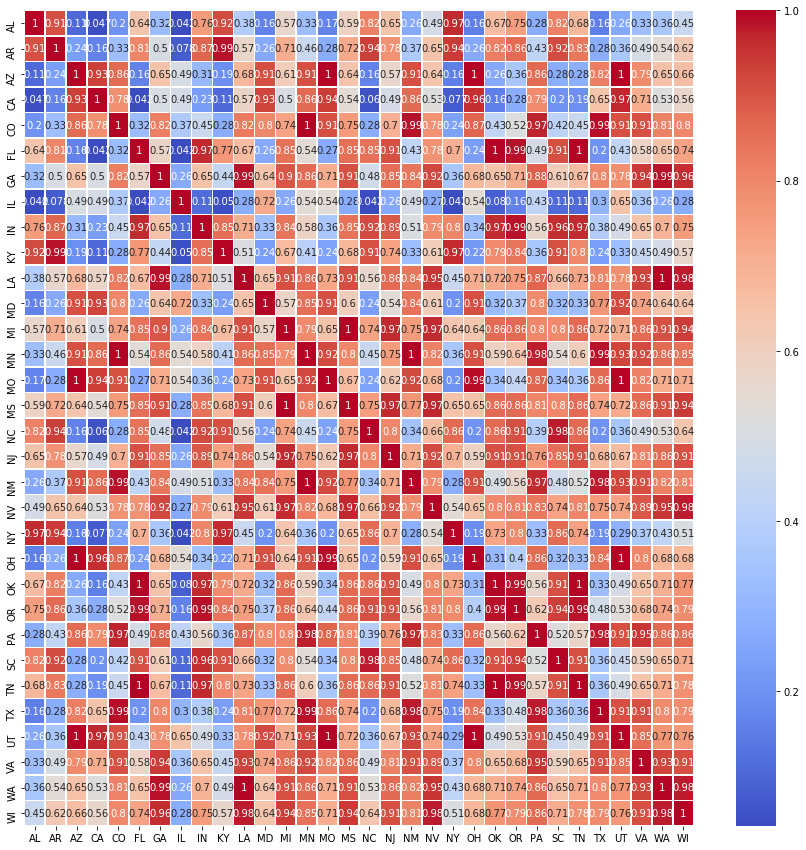

In [25]:
# visualize the results with a heat map ()
fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(p_values, cmap='coolwarm', linewidths=0.5, annot=True) 

'''p-adjust = Benjamini-Hochberg (method performs alpha adjustment based on pairwise tests being rejected 
in sequence rather than simply reducing alpha based on the number of samples as do many p-value adjustment 
methods)'''

Now we'll find out which states have adjusted p-values <= 0.05 (5% significance level) vs. other states.

In [27]:
significant_states = []
for state in p_values.columns: 
    
#iterate through each column of p_values dataframe and append state name if the column contains
#at least one value <= 0.05

    if (p_values[state].min() <= 0.05):
        significant_states.append(state)
    else:
        pass
    
significant_states

['AL', 'CA', 'FL', 'IL', 'NC', 'NY']

Visualize ages by state with violinplots overlaid by swarmplots so you can see what the distribution of 
the victims' ages in each state looks like. We'll make the violins from the significant states red and
the others sky blue.

**Question**: Do signficant differences exist in victims' age distributions between states?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

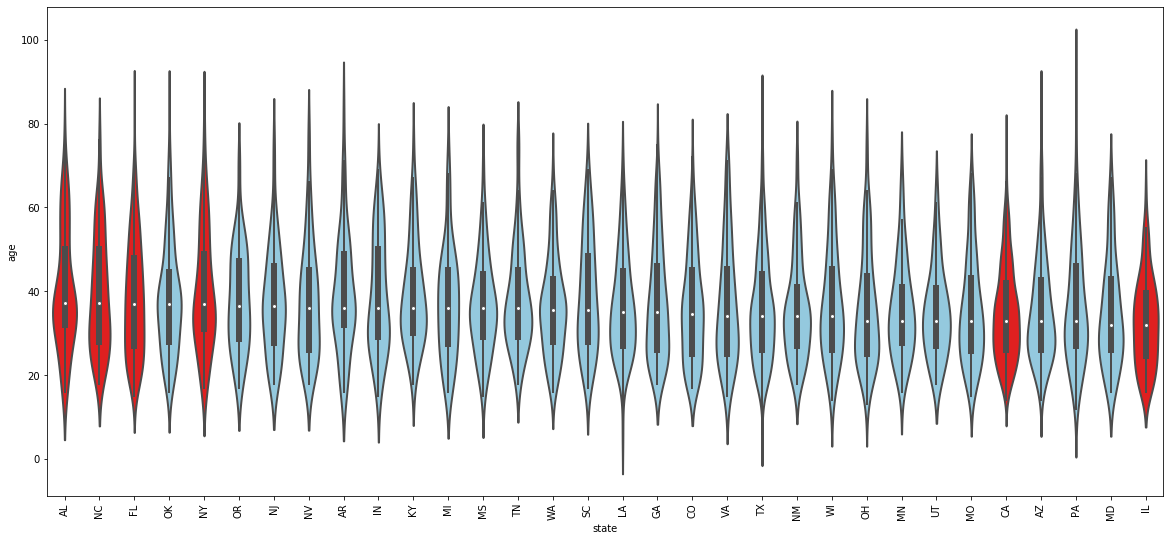

In [28]:
#plot the states' ages in decreasing order (of median age)
shootings_age_sorted_median = shootings_subset.groupby(by=["state"])["age"].median().sort_values().iloc[::-1].index

my_pal = {state: 'r' if state in significant_states else "skyblue" for state in shootings_subset.state.unique()}
fig, ax = plt.subplots(figsize = (20, 9))
ax = sns.violinplot(x = shootings_subset['state'], y = shootings_subset['age'], # make violinplot
                    order = shootings_age_sorted_median, palette = my_pal, linewidth=2)

plt.xticks(rotation=90)


This time it's a bit easier to see why some states had significantly different age distributions of shooting victims. 

#### States with significantly different age distributions that have high medians (AL, NC, FL, NY)
* Four of the states that significantly differ from others are among the 5 highest in terms of median victim age.
* These four states have Q3s with higher ceilings than the fifth state.

#### States with significantly different age distributions that have low medians (CA, IL)
* Two of the states that significantly differ from others are among the 5 lowest in terms of median victim age.
* These two states have Q3s with lower ceilings than the other three states.